In [167]:
# -*- coding: utf-8 -*-
import math

import numpy as np
import pandas as pd
import scipy


In [168]:
import scipy.ndimage
import scipy.signal

In [169]:

def signal_resample(
    signal, desired_length=None, sampling_rate=None, desired_sampling_rate=None, method="interpolation"
):
    """Resample a continuous signal to a different length or sampling rate.
    Up- or down-sample a signal. The user can specify either a desired length for the vector, or input
    the original sampling rate and the desired sampling rate.
    See https://github.com/neuropsychology/NeuroKit/scripts/resampling.ipynb for a comparison of the methods.
    Parameters
    ----------
    signal :  Union[list, np.array, pd.Series]
        The signal (i.e., a time series) in the form of a vector of values.
    desired_length : int
        The desired length of the signal.
    sampling_rate : int
        The original sampling frequency (in Hz, i.e., samples/second).
    desired_sampling_rate : int
        The desired (output) sampling frequency (in Hz, i.e., samples/second).
    method : str
        Can be 'interpolation' (see `scipy.ndimage.zoom()`), 'numpy' for numpy's interpolation
        (see `numpy.interp()`),'pandas' for Pandas' time series resampling, 'poly' (see `scipy.signal.resample_poly()`)
        or 'FFT' (see `scipy.signal.resample()`) for the Fourier method. FFT is the most accurate
        (if the signal is periodic), but becomes exponentially slower as the signal length increases.
        In contrast, 'interpolation' is the fastest, followed by 'numpy', 'poly' and 'pandas'.
    Returns
    -------
    array
        Vector containing resampled signal values.
    Examples
    --------
    >>> import numpy as np
    >>> import pandas as pd
    >>> import neurokit2 as nk
    >>>
    >>> signal = np.cos(np.linspace(start=0, stop=20, num=100))
    >>>
    >>> # Downsample
    >>> downsampled_interpolation = nk.signal_resample(signal, method="interpolation",
    ...                                                sampling_rate=1000, desired_sampling_rate=500)
    >>> downsampled_fft = nk.signal_resample(signal, method="FFT",
    ...                                      sampling_rate=1000, desired_sampling_rate=500)
    >>> downsampled_poly = nk.signal_resample(signal, method="poly",
    ...                                       sampling_rate=1000, desired_sampling_rate=500)
    >>> downsampled_numpy = nk.signal_resample(signal, method="numpy",
    ...                                        sampling_rate=1000, desired_sampling_rate=500)
    >>> downsampled_pandas = nk.signal_resample(signal, method="pandas",
    ...                                         sampling_rate=1000, desired_sampling_rate=500)
    >>>
    >>> # Upsample
    >>> upsampled_interpolation = nk.signal_resample(downsampled_interpolation,
    ...                                              method="interpolation",
    ...                                              sampling_rate=500, desired_sampling_rate=1000)
    >>> upsampled_fft = nk.signal_resample(downsampled_fft, method="FFT",
    ...                                    sampling_rate=500, desired_sampling_rate=1000)
    >>> upsampled_poly = nk.signal_resample(downsampled_poly, method="poly",
    ...                                     sampling_rate=500, desired_sampling_rate=1000)
    >>> upsampled_numpy = nk.signal_resample(downsampled_numpy, method="numpy",
    ...                                      sampling_rate=500, desired_sampling_rate=1000)
    >>> upsampled_pandas = nk.signal_resample(downsampled_pandas, method="pandas",
    ...                                       sampling_rate=500, desired_sampling_rate=1000)
    >>>
    >>> # Compare with original
    >>> fig = pd.DataFrame({"Original": signal,
    ...                     "Interpolation": upsampled_interpolation,
    ...                     "FFT": upsampled_fft,
    ...                     "Poly": upsampled_poly,
    ...                     "Numpy": upsampled_numpy,
    ...                     "Pandas": upsampled_pandas}).plot(style='.-')
    >>> fig #doctest: +SKIP
    >>>
    >>> # Timing benchmarks
    >>> %timeit nk.signal_resample(signal, method="interpolation",
    ...                            sampling_rate=1000, desired_sampling_rate=500) #doctest: +SKIP
    >>> %timeit nk.signal_resample(signal, method="FFT",
    ...                            sampling_rate=1000, desired_sampling_rate=500) #doctest: +SKIP
    >>> %timeit nk.signal_resample(signal, method="poly",
    ...                            sampling_rate=1000, desired_sampling_rate=500) #doctest: +SKIP
    >>> %timeit nk.signal_resample(signal, method="numpy",
    ...                            sampling_rate=1000, desired_sampling_rate=500) #doctest: +SKIP
    >>> %timeit nk.signal_resample(signal, method="pandas",
    ...                            sampling_rate=1000, desired_sampling_rate=500) #doctest: +SKIP
    See Also
    --------
    scipy.signal.resample_poly, scipy.signal.resample, scipy.ndimage.zoom
    """
    if desired_length is None:
        desired_length = int(np.round(len(signal) * desired_sampling_rate / sampling_rate))

    # Sanity checks
    if len(signal) == desired_length:
        return signal

    # Resample

    resampled = _resample_interpolation(signal, desired_length)

    return resampled


# =============================================================================
# Methods
# =============================================================================
def _resample_interpolation(signal, desired_length):
    resampled_signal = scipy.ndimage.zoom(signal, desired_length / len(signal))
    return resampled_signal

In [170]:
# =============================================================================
# ECGSYN
# =============================================================================
def _ecg_simulate_ecgsyn(
    sfecg=256,
    N=256,
    Anoise=0,
    hrmean=60,
    hrstd=1,
    lfhfratio=0.5,
    sfint=512,
    ti=(-70, -15, 0, 15, 100),
    ai=(1.2, -5, 30, -7.5, 0.75),
    bi=(0.25, 0.1, 0.1, 0.1, 0.4),
):
    """This function is a python translation of the matlab script by `McSharry & Clifford (2013)

    <https://physionet.org/content/ecgsyn>`_.

    Parameters
    ----------
    % Operation uses the following parameters (default values in []s):
    % sfecg: ECG sampling frequency [256 Hertz]
    % N: approximate number of heart beats [256]
    % Anoise: Additive uniformly distributed measurement noise [0 mV]
    % hrmean: Mean heart rate [60 beats per minute]
    % hrstd: Standard deviation of heart rate [1 beat per minute]
    % lfhfratio: LF/HF ratio [0.5]
    % sfint: Internal sampling frequency [256 Hertz]
    % Order of extrema: (P Q R S T)
    % ti = angles of extrema (in degrees)
    % ai = z-position of extrema
    % bi = Gaussian width of peaks

    Returns
    -------
    array
        Vector containing simulated ecg signal.

#    Examples
#    --------
#    >>> import matplotlib.pyplot as plt
#    >>> import neurokit2 as nk
#    >>>
#    >>> s = _ecg_simulate_ecgsynth()
#    >>> x = np.linspace(0, len(s)-1, len(s))
#    >>> num_points = 4000
#    >>>
#    >>> num_points = min(num_points, len(s))
#    >>> plt.plot(x[:num_points], s[:num_points]) #doctest: +SKIP
#    >>> plt.show() #doctest: +SKIP

    """

    if not isinstance(ti, np.ndarray):
        ti = np.array(ti)
    if not isinstance(ai, np.ndarray):
        ai = np.array(ai)
    if not isinstance(bi, np.ndarray):
        bi = np.array(bi)

    ti = ti * np.pi / 180

    # Adjust extrema parameters for mean heart rate
    hrfact = np.sqrt(hrmean / 60)
    hrfact2 = np.sqrt(hrfact)
    bi = hrfact * bi
    ti = np.array([hrfact2, hrfact, 1, hrfact, hrfact2]) * ti

    # Check that sfint is an integer multiple of sfecg
    q = np.round(sfint / sfecg)
    qd = sfint / sfecg
    if q != qd:
        raise ValueError(
            "Internal sampling frequency (sfint) must be an integer multiple of the ECG sampling frequency"
            " (sfecg). Your current choices are: sfecg = " + str(sfecg) + " and sfint = " + str(sfint) + "."
        )

    # Define frequency parameters for rr process
    # flo and fhi correspond to the Mayer waves and respiratory rate respectively
    flo = 0.1
    fhi = 0.25
    flostd = 0.01
    fhistd = 0.01

    # Calculate time scales for rr and total output
    sfrr = 1
    trr = 1 / sfrr
    rrmean = 60 / hrmean
    n = 2 ** (np.ceil(np.log2(N * rrmean / trr)))

    rr0 = _ecg_simulate_rrprocess(flo, fhi, flostd, fhistd, lfhfratio, hrmean, hrstd, sfrr, n)

    # Upsample rr time series from 1 Hz to sfint Hz
    rr = signal_resample(rr0, sampling_rate=1, desired_sampling_rate=sfint)

    # Make the rrn time series
    dt = 1 / sfint
    rrn = np.zeros(len(rr))
    tecg = 0
    i = 0
    while i < len(rr):
        tecg += rr[i]
        ip = int(np.round(tecg / dt))
        rrn[i:ip] = rr[i]
        i = ip
    Nt = ip

    # Integrate system using fourth order Runge-Kutta
    x0 = np.array([1, 0, 0.04])

    # tspan is a tuple of (min, max) which defines the lower and upper bound of t in ODE
    # t_eval is the list of desired t points for ODE
    # in Matlab, ode45 can accepts both tspan and t_eval in one argument
    Tspan = [0, (Nt - 1) * dt]
    t_eval = np.linspace(0, (Nt - 1) * dt, Nt)
    
    # as passing extra arguments to derivative function is not supported yet in solve_ivp
    # lambda function is used to serve the purpose
    result = scipy.integrate.solve_ivp(
        lambda t, x: _ecg_simulate_derivsecgsyn(t, x, rrn, ti, sfint, ai, bi), Tspan, x0, t_eval=t_eval
    )
    X0 = result.y
    

    # downsample to required sfecg
    X = X0[:, np.arange(0, X0.shape[1], q).astype(int)]
    # return X

    # Scale signal to lie between -0.4 and 1.2 mV
    z = X[2, :].copy()
    zmin = np.min(z)
    zmax = np.max(z)
    zrange = zmax - zmin
    z = (z - zmin) * 1.6 / zrange - 0.4
    return z

    # include additive uniformly distributed measurement noise
    eta = 2 * np.random.uniform(len(z)) - 1
    return z + Anoise * eta  # Return signal


def _ecg_simulate_derivsecgsyn(t, x, rr, ti, sfint, ai, bi):

    ta = math.atan2(x[1], x[0])
    r0 = 1
    a0 = 1.0 - np.sqrt(x[0] ** 2 + x[1] ** 2) / r0

    ip = np.floor(t * sfint).astype(int)
    w0 = 2 * np.pi / rr[min(ip, len(rr) - 1)]
    
    # w0 = 2*np.pi/rr[ip[ip <= np.max(rr)]]

    fresp = 0.25
    zbase = 0.005 * np.sin(2 * np.pi * fresp * t)

    dx1dt = a0 * x[0] - w0 * x[1]
    dx2dt = a0 * x[1] + w0 * x[0]
 
    # matlab rem and numpy rem are different
    # dti = np.remainder(ta - ti, 2*np.pi)
    dti = (ta - ti) - np.round((ta - ti) / 2 / np.pi) * 2 * np.pi
    
    dx3dt = -np.sum(ai * dti * np.exp(-0.5 * (dti / bi) ** 2)) - 1 * (x[2] - zbase)

    dxdt = np.array([dx1dt, dx2dt, dx3dt])
    return dxdt


def _ecg_simulate_rrprocess(
    flo=0.1, fhi=0.25, flostd=0.01, fhistd=0.01, lfhfratio=0.5, hrmean=60, hrstd=1, sfrr=1, n=256
):
    w1 = 2 * np.pi * flo
    w2 = 2 * np.pi * fhi
    c1 = 2 * np.pi * flostd
    c2 = 2 * np.pi * fhistd
    sig2 = 1
    sig1 = lfhfratio
    rrmean = 60 / hrmean
    rrstd = 60 * hrstd / (hrmean * hrmean)

    df = sfrr / n
    w = np.arange(n) * 2 * np.pi * df
    dw1 = w - w1
    dw2 = w - w2

    Hw1 = sig1 * np.exp(-0.5 * (dw1 / c1) ** 2) / np.sqrt(2 * np.pi * c1 ** 2)
    Hw2 = sig2 * np.exp(-0.5 * (dw2 / c2) ** 2) / np.sqrt(2 * np.pi * c2 ** 2)
    Hw = Hw1 + Hw2
    Hw0 = np.concatenate((Hw[0 : int(n / 2)], Hw[int(n / 2) - 1 :: -1]))
    Sw = (sfrr / 2) * np.sqrt(Hw0)

    ph0 = 2 * np.pi * np.random.uniform(size=int(n / 2 - 1))
    ph = np.concatenate([[0], ph0, [0], -np.flipud(ph0)])
    SwC = Sw * np.exp(1j * ph)
    x = (1 / n) * np.real(np.fft.ifft(SwC))

    xstd = np.std(x)
    ratio = rrstd / xstd
    return rrmean + x * ratio  # Return RR

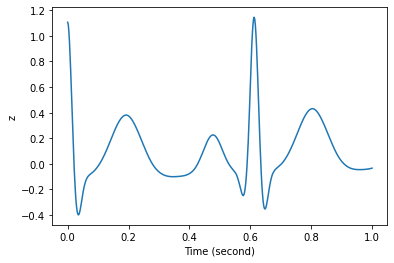

In [171]:
duration=1
length=None 
sampling_rate=512
heart_rate=100
heart_rate_std=1

# Generate number of samples automatically if length is unspecified
if length is None:
    length = duration * sampling_rate
if duration is None:
    duration = length / sampling_rate

# Run appropriate method
approx_number_beats = int(np.round(duration * (heart_rate / 60)))
ecg = _ecg_simulate_ecgsyn(
    sfecg=sampling_rate,
    N=approx_number_beats,
    Anoise=0,
    hrmean=heart_rate,
    hrstd=heart_rate_std,
    lfhfratio=0.5,
    sfint=sampling_rate
)

# Cut to match expected length
ecg = ecg[0:length]

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# x axis - timeline (sampling_rate is number of signal in one second)
t = np.linspace(0, length, length)
t = t / sampling_rate

# plot results
plt.plot(t, ecg)
plt.xlabel('Time (second)')
plt.ylabel('z')
plt.show()